In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import sktime
from datetime import datetime
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.utils.plotting import plot_series
import sklearn
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [45]:
excluded_columns = ['Total Load', 'Difference with previous load', 'Datetime', 'Resolution code', 'Total Load Persistence', 
                   'Most recent forecast', 'Most recent P10', 'Most recent P90', 'Day-ahead 6PM forecast',
                    'Day-ahead 6PM P10', 'Day-ahead 6PM P90', 'Week-ahead forecast', 'Total Load Interpolated Persistence',
                    'Difference with previous load interpolated']
def get_windows(y, cv, shift):
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y["Total Load Interpolated"])):
        if not (i%shift):
            train_windows.append(y[y.columns[~y.columns.isin(excluded_columns)]].loc[train].to_numpy().flatten())
            test_windows.append(y.loc[test, ["Total Load Interpolated"]].to_numpy().flatten())
    return train_windows, test_windows

In [46]:
data = pd.read_csv("Processed_data.csv")[int(-24*4*365*1.5):].reset_index()
data = data.drop([data.columns[0], data.columns[1]], axis=1)

In [47]:
data.columns[~data.columns.isin(excluded_columns)]

Index(['Total Load Interpolated', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'Season', 'Lockdown'],
      dtype='object')

In [81]:
window_length = 4*2
horizon = 4
shift = 4
fh = ForecastingHorizon(list(range(1, horizon+1)))
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)
n_splits = cv.get_n_splits(data)

In [82]:
x, y = get_windows(data, cv, shift)

The models take as input:

In [83]:
x[0].shape

(64,)

And output a vector of size:

In [84]:
y[0].shape

(4,)

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
X_train, X_test, Y_train, Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)

The datasets dimensions are then:

In [86]:
print("Input training set:", X_train.shape)
print("Output training set:", X_test.shape)
print("Input testing set:", X_test.shape)
print("Output testing set:", Y_test.shape)

Input training set: (10510, 64)
Output training set: (2628, 64)
Input testing set: (2628, 64)
Output testing set: (2628, 4)


In [87]:
def err(Y_test, y_hat, horizon):
    errors = pd.DataFrame()
    errors["RMSE"] = [root_mean_squared_error(Y_test[:, i], y_hat[:, i]) for i in range(horizon)]
    errors["MAPE"] = [mean_absolute_percentage_error(Y_test[:, i], y_hat[:, i]) for i in range(horizon)]
    errors["MAE"] = [mean_absolute_error(Y_test[:, i], y_hat[:, i]) for i in range(horizon)]
    errors["MSE"] = [mean_squared_error(Y_test[:, i], y_hat[:, i]) for i in range(horizon)]
    return errors.T

In [88]:
from sklearn.linear_model import LinearRegression
tree = LinearRegression(n_jobs=-1)
tree = tree.fit(X_train, Y_train)
y_hat = tree.predict(X_test)
err(Y_test, y_hat, horizon)

,0,1,2,3
RMSE,70.323294,130.730133,180.407206,221.924850
MAPE,0.006531,0.012072,0.016784,0.020550
MAE,55.240688,101.984707,141.898740,173.666551
MSE,4945.365620,17090.367767,32546.759949,49250.638992


In [89]:
from sklearn.linear_model import Ridge
tree = Ridge(alpha=10000)
tree = tree.fit(X_train, Y_train)
y_hat = tree.predict(X_test)
err(Y_test, y_hat, horizon)

,0,1,2,3
RMSE,70.316868,129.136588,176.350299,217.443150
MAPE,0.006528,0.011907,0.016353,0.020112
MAE,55.222136,100.672349,138.484681,170.255694
MSE,4944.461875,16676.258256,31099.428123,47281.523296


In [90]:
tree = RandomForestRegressor(n_jobs=-1)
tree = tree.fit(X_train, Y_train)
y_hat = tree.predict(X_test)
err(Y_test, y_hat, horizon)

,0,1,2,3
RMSE,72.922878,117.855922,151.907558,181.323774
MAPE,0.006709,0.010733,0.013808,0.016351
MAE,56.866311,91.075731,117.763807,139.768830
MSE,5317.746119,13890.018299,23075.906236,32878.311130


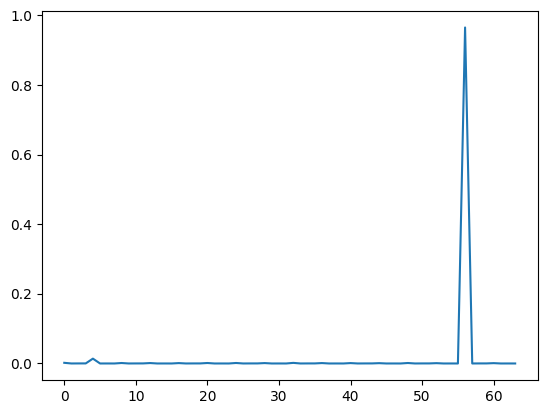

In [91]:
plt.plot(tree.feature_importances_)

from sklearn.linear_model import MultiTaskLasso
tree = MultiTaskLasso(max_iter=10000)
tree = tree.fit(X_train, Y_train)
y_hat = tree.predict(X_test)
err(Y_test, y_hat, horizon)

Take the vector of the errors, compute the mean and autocorellation (-> 0 and higher possible)

from sklearn.neural_network import MLPRegressor
tree = MLPRegressor(max_iter=10000)
tree = tree.fit(X_train, Y_train)
y_hat = tree.predict(X_test)
err(Y_test, y_hat, horizon)